<a id='sommaire'></a>
<h1 style='text-align:center;border:5px double;border-color:#146e10;'>
    <br/>
    PROJET 7<br/>
    <br/>
    "Effectuez une prédiction de revenus"
    <br/>
    
</h1>




# [Mission 3](#m3)  
* [Ajout du coefficient d'élasticité](#ajout)  
* [Protocole du calcul de distribution condition conditionnelles](#proto)  
* [Application du protocole sur nos données](#appli)  

In [1]:
# Calculs & dataframes
import pandas as pd
import numpy as np
import matplotlib
# Librairies graphiques
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import seaborn as sns

from collections import Counter
import random



import scipy.stats as st
import pingouin as pg
import statsmodels
import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor


<a id='m3'></a>
## Misson 3


<b>Dans l'état actuel</b>, nous avons à disposition deux des trois variables explicatives souhaitées :<br><br>
    - \(m_{j}\) le revenu moyen du pays  \(j\) <br>
    - \(G_{j}\) l'indice de Gini du pays \(j\) <br><br>
Il nous manque donc, pour un individu  \(i\) , la classe de revenu \(c_{i,parent}\) de ses parents.
</p>
<br>
<div class="admonition note alert alert-info" style="color:#4cb2ff"><b>
Nous supposons ici que l'on associe à chaque individu \(i\) une unique classe \(c_{i,parent}\) ; quel que soit le nombre de parents de \(i\).
</b></div>
                                                              
<p>
Nous allons donc simuler cette information grâce à un coefficient \(\rho_{j}\) (propre à chaque pays \(j\) ), mesurant une corrélation entre le revenu de l'individu \(i\) et le revenu de ses parents. Ce coefficient sera ici appelé coefficient d'élasticité ; il mesure la mobilité intergénérationnelle du revenu.
</p>
<p><b>  L'élasticité intergénérationnelle des revenus : quelle est la probabilité qu'un enfant, une fois adulte, gagne plus que ses parents. C'est un indice de mesure de l'ascenseur social.   
</b></p>    
<br>                                                         
<div class="admonition note alert alert-info" style="color:#4cb2ff">
Pour plus d'informations sur le calcul du coefficient d'élasticité, consulter ce <a href="https://s3-eu-west-1.amazonaws.com/static.oc-static.com/prod/courses/files/parcours-data-analyst/2011-measuring-intergenerational-income-mobility-art.pdf">document</a>, notamment l'équation 1 de la page 8. <b>Ce coefficient est déterminé par une régression linéaire simple dans laquelle le logarithme du revenu de l'enfant \(Y_{child}\) est une fonction du logarithme du revenu des parents \(Y_{parent}\) :
\[ln(Y_{child}) = \alpha + \rho_j\ ln(Y_{parent}) + \epsilon\] </b> 
</div>

<p><br>
Pour obtenir le coefficient d'élasticité, deux possibilités s'offrent à vous : <br>
<br>    
<li>Vous baser sur ces coefficients donnés par la Banque mondiale, dans GDIM dataset : <a href="http://www.worldbank.org/en/topic/poverty/brief/what-is-the-global-database-on-intergenerational-mobility-gdim"> dataset</a>. Le coefficient d'élasticité est donné pour certains pays, sous le nom d'IGE Income (relative IGM in income). </li><br>
<li>Vous baser sur des estimations provenant de multiples études, extrapolées à différentes régions du monde :  elles se trouvent dans le fichier <a href="https://s3-eu-west-1.amazonaws.com/static.oc-static.com/prod/courses/files/parcours-data-analyst/projet_7.zip">elasticity.txt</a>.</li><br></p>
   
<p>
Attention, ces données sont parfois anciennes. <br>
Il est aussi possible de combiner ces deux approches. <br>
Pour chaque pays, nous allons utiliser une génération aléatoire de la classe de revenu des parents, à partir de ces seules deux informations : 
\(\rho_j\) la classe de revenu de l'enfant  \(c_{i,child}\).
</p>
<br>
<div class="alert alert-block alert-warning">
Attention à bien utiliser la classe de revenu de l'enfant (qui est un nombre compris entre 1 et 100 si vous utilisez 100 quantiles), plutôt que son revenu PPP. De même, on ne cherche pas à générer le revenu des parents, mais la classe de revenu des parents \(c_{i,parent}\).
</div> 

<p>
Voici le protocole de génération pour un pays \(j\) donné, qui se base sur l'équation donnée ci dessus : </p>
<br>
<div class="admonition note alert alert-info" style="color:#4cb2ff">
Un exemple de code permettant de réaliser les opérations 1 à 6 est donné tout en bas. Libre à vous de l'utiliser. Notamment, la fonction  proba_cond  vous donnera les probabilités \(P(c_{i,parent} \ | \ c_{i,child,} \ \rho_{j=0.9})\). 
</div>

In [2]:
# Chargement des données
df= pd.read_csv('analyse1.csv')
df.head()

,country,country_code,population,quantile,income,gdpppp,Gini,income_avg
0,Albania,ALB,2947314.0,1,728.89795,7297.0,0.32141,2994.829902
1,Albania,ALB,2947314.0,2,916.66235,7297.0,0.32141,2994.829902
2,Albania,ALB,2947314.0,3,1010.91600,7297.0,0.32141,2994.829902
3,Albania,ALB,2947314.0,4,1086.90780,7297.0,0.32141,2994.829902
4,Albania,ALB,2947314.0,5,1132.69970,7297.0,0.32141,2994.829902


<a id='ajout'></a>
<h2 style='color:#8677b2'>Ajout du coefficient d'élasticité</h2>



[Haut de page](#sommaire)

In [3]:
#Chargement et traitement des données GDIM
gdim = pd.read_csv('data/GDIMMay2018.csv').loc[:, ['countryname', 'iso3', 'region', 'IGEincome']]
gdim.rename(columns={'countryname': 'country', 'iso3' : 'country_code'}, inplace=True)
gdim.drop_duplicates(inplace=True)
gdim.drop_duplicates(subset=['country'], keep = 'last', inplace=True)
display(gdim.head(10))


,country,country_code,region,IGEincome
0,Afghanistan,AFG,South Asia,NaN
12,Angola,AGO,Sub-Saharan Africa,NaN
60,Albania,ALB,Europe & Central Asia,0.815874
84,Argentina,ARG,Latin America & Caribbean,NaN
99,Armenia,ARM,Europe & Central Asia,NaN
183,Australia,AUS,High income,0.275000
243,Austria,AUT,High income,0.245267
279,Azerbaijan,AZE,Europe & Central Asia,NaN
351,Belgium,BEL,High income,0.183176
405,Benin,BEN,Sub-Saharan Africa,0.855116


In [4]:
#Isolement des pays sans valeur pour la variable 'IGEincome'
missing_gdim = gdim[gdim['IGEincome'].isna()]
display(missing_gdim.tail())
display(len(missing_gdim))

,country,country_code,region,IGEincome
6298,"Venezuela, RB",VEN,Latin America & Caribbean,NaN
6366,Vanuatu,VUT,East Asia & Pacific,NaN
6378,West Bank and Gaza,PSE,Middle East & North Africa,NaN
6390,"Yemen, Rep.",YEM,Middle East & North Africa,NaN
6492,Zambia,ZMB,Sub-Saharan Africa,NaN


77

In [5]:
#Identification des pays sans valeur pour la variable 'IGEincome'
missing_countries_gdim = missing_gdim['country_code'].unique()
missing_countries_gdim = list(missing_countries_gdim)
len(missing_countries_gdim)


77

In [6]:
missing_countries_gdim

['AFG',
 'AGO',
 'ARG',
 'ARM',
 'AZE',
 'BFA',
 'BGD',
 'BGR',
 'BTN',
 'BWA',
 'CAF',
 'CIV',
 'CMR',
 'COG',
 'COM',
 'CPV',
 'CRI',
 'DJI',
 'DOM',
 'EST',
 'FJI',
 'GAB',
 'GEO',
 'GNB',
 'HND',
 'HUN',
 'IDN',
 'IRN',
 'IRQ',
 'ISL',
 'ISR',
 'KHM',
 'KIR',
 'KSV',
 'LAO',
 'LBN',
 'LBR',
 'LKA',
 'LSO',
 'LTU',
 'MDA',
 'MDV',
 'MEX',
 'MNE',
 'MOZ',
 'MRT',
 'MUS',
 'MYS',
 'NAM',
 'NER',
 'NIC',
 'PHL',
 'PNG',
 'POL',
 'PRY',
 'SDN',
 'SEN',
 'SLE',
 'SLV',
 'SRB',
 'SSD',
 'STP',
 'SWZ',
 'TCD',
 'TGO',
 'THA',
 'TJK',
 'TON',
 'TUR',
 'TUV',
 'UKR',
 'URY',
 'VEN',
 'VUT',
 'PSE',
 'YEM',
 'ZMB']

In [7]:
#Visualisation des régions concernées 
list(missing_gdim.region.unique())

['South Asia',
 'Sub-Saharan Africa',
 'Latin America & Caribbean',
 'Europe & Central Asia',
 'Middle East & North Africa',
 'High income',
 'East Asia & Pacific']

In [8]:
#Visualisation des pays concernés par la région 'High income'
missing_gdim[missing_gdim['region'] == 'High income']['country'].unique()

array(['Estonia', 'Hungary', 'Iceland', 'Israel', 'Lithuania', 'Poland',
       'Uruguay'], dtype=object)

**Des estimations provenant de multiples études, extrapolées à différentes régions du monde :   dans le fichier elasticity.txt.** 

| Region                             | Base Case       | Optimistic (high mobility) | Pessimistic (low mobility) |
| :--------------------------------- |:---------------:|:--------------------------:|:--------------------------:| 
| Nordic European countries & Canada | 0.2             | 0.15                       | 0.3                        |
| Europe (except nordic countries)   | 0.4             | 0.3                        | 0.5                        |
| Australia/New Zealand/USA          | 0.4             | 0.3                        | 0.5                        |
| Asia                               | 0.5             | 0.4                        | 0.6                        |
| Latin America/Africa               | 0.66            | 0.5                        | 0.9                        |


In [9]:
#Boucle itérative afin d'imputer les valeurs NaN sur la variable 'IGEincome'
for code in missing_countries_gdim :
    if list(gdim.loc[gdim['country_code'] == code, 'region']) == ['South Asia']:
        gdim.loc[gdim['country_code'] == code, 'IGEincome'] = 0.50
    elif list(gdim.loc[gdim['country_code'] == code, 'region']) == ['Sub-Saharan Africa']:
        gdim.loc[gdim['country_code'] == code, 'IGEincome'] = 0.66
    elif list(gdim.loc[gdim['country_code'] == code, 'region']) == ['Latin America & Caribbean']:
        gdim.loc[gdim['country_code'] == code, 'IGEincome'] = 0.66
    elif list(gdim.loc[gdim['country_code'] == code, 'region']) == ['Europe & Central Asia']:
        gdim.loc[gdim['country_code'] == code, 'IGEincome'] = 0.40                                                               
    elif list(gdim.loc[gdim['country_code'] == code, 'region']) == ['East Asia & Pacific']:
        gdim.loc[gdim['country_code'] == code, 'IGEincome'] = 0.50
    else : gdim.loc[gdim['country_code'] == code, 'IGEincome'] =  0.40 
        

In [10]:
#Jointure avec notre dataframe 'df' et celui obtenu 'gdim'
#'IGEincome' sera renommé en 'pj'
df_income_mobility = pd.merge(df, gdim[['country_code', 'IGEincome']], how='left', on='country_code')
df_income_mobility.rename(columns={'IGEincome': 'pj'}, inplace=True)
df_income_mobility.head()


,country,country_code,population,quantile,income,gdpppp,Gini,income_avg,pj
0,Albania,ALB,2947314.0,1,728.89795,7297.0,0.32141,2994.829902,0.815874
1,Albania,ALB,2947314.0,2,916.66235,7297.0,0.32141,2994.829902,0.815874
2,Albania,ALB,2947314.0,3,1010.91600,7297.0,0.32141,2994.829902,0.815874
3,Albania,ALB,2947314.0,4,1086.90780,7297.0,0.32141,2994.829902,0.815874
4,Albania,ALB,2947314.0,5,1132.69970,7297.0,0.32141,2994.829902,0.815874


In [11]:
#Vérification des éventuelles valeurs manquantes
last_list_missing_countries = list(df_income_mobility[df_income_mobility['pj'].isna()]['country'].unique())
last_list_missing_countries

['Kosovo', 'Syrian Arab Republic (Syria)']

La Syrie est un pays d'Asie de l'Ouest > pj = 0.50\ Le Kosovo est un pays d'Europe du Sud > pj = 0.40

In [12]:
#Imputation des 2 dernières valeurs NaN dans le dataframe 

df_income_mobility.loc[df_income_mobility['country'] == 'Kosovo', 'pj'] = 0.40

df_income_mobility.loc[df_income_mobility['country'] == 'Syrian Arab Republic (Syria)', 'pj'] = 0.50

In [13]:
#Dernière validation de la complétude du dataframe "df_income_mobility"
df_income_mobility.isna().any()

country         False
country_code    False
population      False
quantile        False
income          False
gdpppp          False
Gini            False
income_avg      False
pj              False
dtype: bool

In [14]:
#Visualisation des premières lignes de l'échantillon 
display(df_income_mobility.head())
display(df_income_mobility.shape)

,country,country_code,population,quantile,income,gdpppp,Gini,income_avg,pj
0,Albania,ALB,2947314.0,1,728.89795,7297.0,0.32141,2994.829902,0.815874
1,Albania,ALB,2947314.0,2,916.66235,7297.0,0.32141,2994.829902,0.815874
2,Albania,ALB,2947314.0,3,1010.91600,7297.0,0.32141,2994.829902,0.815874
3,Albania,ALB,2947314.0,4,1086.90780,7297.0,0.32141,2994.829902,0.815874
4,Albania,ALB,2947314.0,5,1132.69970,7297.0,0.32141,2994.829902,0.815874


(11600, 9)

L'échantillon contient 11600 individus, notre échantillon de travail a désormais son coefficient d'élasticité qui mesure la mobilité intergénérationnelle du revenu. A partir des 3 variables explicatives le revenu moyen du pays, l'indice de Gini du pays et le coefficient d'élasticité, nous pourrons générer des classes de revenu des parents.

<a id='proto'></a>
 <h2 style='color:#6b21eb'>Protocole du calcul de distribution condition conditionnelles</h2>
    
    

[Haut de page](#sommaire)


### Revenus des parents selon une loi normale (de moyenne 0 et d'écart-type 1)
### Terme d'erreur ϵ selon une loi normale (de moyenne 0 et d'écart-type 1)
### Revenus des enfants ychild

<ol><li>Générez un grand nombre \(n\) de réalisations d'une variable que nous appellerons  \(ln(Y_{parent})\) selon une loi normale. Le choix de la moyenne et de l'écart type n'auront pas d'incidence sur le résultat final. \(n\) doit être supérieur à 1000 fois le nombre de quantiles.</li>
<br>
<li>Générez \(n\) réalisations du terme d'erreur \(\epsilon\) selon une loi normale de moyenne 0 et d'écart type 1.</li>
<br>    
<li>Pour une valeur donnée de \(\rho_j\) (par exemple 0.9), calculez \(y_{child} = e^{\alpha+\rho_jln(y_{parent})+\epsilon}\) . Le choix de \( \alpha\) n'a aucune incidence sur le résultat final et peut être supprimé. À ce stade, \(y_{child}\) contient des valeurs dont l'ordre de grandeur ne reflète pas la réalité, mais cela n'a pas d'influence pour la suite. <p><b> ln(Ychild) = α + β1 ln(Yparent) + ε.</b> </p></li></ol>



Les revenus des parents (exprimés en logs) sont générés de façon aléatoires selon une loi normale. La moyenne et variance n'ont aucune incidence sur le résultat final. n doit-être supérieur à 1000 fois le nombre de quantiles.

In [15]:
def generate_incomes(n, pj):
    
    """
    Paramètres : 
        n : nombre de réalisations
        pj : coefficient d'élasticité du pays j
        
    Renvoie les n salaires enfants et les n salaires des parents respectifs
    """
    
    # On génère les revenus des parents (exprimés en logs) selon une loi normale.
    # La moyenne et variance n'ont aucune incidence sur le résultat final (ie. sur le caclul de la classe de revenu)
    ln_y_parent = st.norm(0,1).rvs(size=n)
    
    # Génération d'une réalisation du terme d'erreur epsilon
    residues = st.norm(0,1).rvs(size=n)
    
    # On calcule le salaire des enfants en fonction de la fonction linéaire et de l'indice d'élasticité pj
    return np.exp(pj*ln_y_parent + residues), np.exp(ln_y_parent)
# .rvs : Random variates of given type.
# st.norm: A normal continuous random variable.    
#np.exp : Calculate the exponential of all elements in the input array.

In [16]:
#elasticity coefficient of country j
pj = 0.9 

#number of quantiles (number of income classes)
nb_quantiles = 100

#sample size
n = 1000 * nb_quantiles  

#calculation
y_child, y_parents = generate_incomes(n, pj)

In [17]:
# Les revenu des parents
y_parents

array([0.63007056, 0.98155926, 0.6188077 , ..., 0.34280492, 1.36856473,
       0.41555215])

In [18]:
#Les revenu de l'enfant
y_child

array([0.24469125, 1.4455615 , 3.95829995, ..., 0.39869231, 0.84740042,
       2.00589859])


## Calcul des classes de revenu des enfants et des parents selon les n individus générés précédemment


<ol start="4">
<li>Pour chacun des \(n\) individus générés, calculez la classe de revenu  \(c_{i,child}\) ainsi que la classe de revenu de ses parents \(c_{i,parent}\) , à partir de \(y_{child}\) et \(y_{parent}\).</li> </ol>


In [19]:
def quantiles(l, nb_quantiles):
    
    """
    Paramètres : 
        l (série) 
        nb_quantiles
        
    Renvoie une série indiquant le quantile qui correspond a chaque valeur de l
    """
    
    size = len(l) #La fonction len() renvoie le nombre d'éléments (longueur) dans un objet.
    l_sorted = l.copy()
    l_sorted = l_sorted.sort_values()
    quantiles = np.round(np.arange(1, nb_quantiles+1, nb_quantiles/size) -0.5 +1./size)
    q_dict = {a:int(b) for a,b in zip(l_sorted,quantiles)}
    return pd.Series([q_dict[e] for e in l])


def compute_quantiles(y_child, y_parents, nb_quantiles):
    
    """
    Paramètres : 
        y_child : revenu enfant (array)
        y_parents : revenu parents (array) 
        nb_quantiles
        
    Renvoie un dataframe
    """
    
    y_child = pd.Series(y_child)
    y_parents = pd.Series(y_parents)
    
    c_i_child = quantiles(y_child, nb_quantiles)
    c_i_parent = quantiles(y_parents, nb_quantiles)
    
    sample = pd.concat([y_child, y_parents, c_i_child, c_i_parent], axis=1)
    sample.columns = ["y_child", "y_parents", "c_i_child","c_i_parent"]
    
    return sample

In [20]:
sample = compute_quantiles(y_child, y_parents, nb_quantiles)
sample

,y_child,y_parents,c_i_child,c_i_parent
0,0.244691,0.630071,15,33
1,1.445561,0.981559,61,50
2,3.958300,0.618808,85,32
3,0.529122,0.208421,32,6
4,0.611321,0.345773,36,15
...,...,...,...,...
99995,1.052015,0.704106,52,37
99996,0.895837,0.394558,47,18
99997,0.398692,0.342805,25,15
99998,0.847400,1.368565,46,63


L'échantillon a été réalisé de façon aléatoire, d'un côté nous avons les individus, et de l'autre, ce qui nous intéresse, les classes de revenu enfants et parents.




## Estimation de la distribution conditionnelle des classes de revenus parents pour chaque classe enfant

<ol start=5><li>À partir de cette dernière information, estimez pour chaque  \(c_{i,child}\) la distribution conditionnelle de \(c_{i,parent}\) . Par exemple, si vous observez 6 individus ayant à la fois  \(c_{i,child} = 5\) et \(c_{i,parent} = 8\) , et que 200 individus sur 20000 ont \( c_{i,child} = 5\) , alors la probabilité d'avoir \( c_{i,parent} = 8\) sachant  \(c_{i,child} = 5\) et sachant \(\rho_j=0.9\) sera estimée à 6/200 (On note cette probabilité comme ceci : \(P(c_{i,parent}=8|c_{i,child}=5,\rho_j=0.9) = 0.03\)). Si votre population est divisée en \(c\) classes de revenu, vous devriez alors avoir \(c^2\) estimations de ces probabilités conditionnelles, pour chaque pays.</li></ol>

In [21]:
def distribution(counts, nb_quantiles):
    
    """
    Paramètres : 
        counts (df) : c_i_child | c_i_parent | counts 
            c_i_child : fixée,
            c_i_parent : la classe des parents, 
            counts : le nombre d'individus représentés (enfant / parents)
        nb_quantiles

    Renvoie la distribution des classes de revenu des parents pour la classe enfant sour la forme d'un array à une 
    dimension (i+1 étant la classe des parents).
    """
    
    distrib = []
    # On compte le nombre totale d'individus
    total = counts["counts"].sum()
    
    # S'il n'y a aucun individus, une ligne de 0 est renvoyée
    if total == 0 :
        return [0] * nb_quantiles
    
    # Pour chaque quantiles parents
    for q_p in range(1, nb_quantiles+1):
         # On ne garde que les lignes du quantile parent concerné
        subset = counts[counts.c_i_parent == q_p]
        
        if len(subset):
            # Si la longueur n'est pas nulle, on ajoute au resultat la fréquence d'apparition de q_p
            nb = subset["counts"].values[0]
            distrib += [nb / total]
        else:
            distrib += [0]
    
    return distrib   


def conditional_distributions(sample, nb_quantiles):
    
    """
    Paramètres : 
        sample (df) : y_child | y_parents | c_i_child | c_i_parents
        nb_quantiles
        
    Renvoie une matrice à deux dimensions :
        - une ligne par quantile enfant
        - au sein d'une ligne, on a la distribution des quantiles des parents
        Les valeurs peuvent être interprétées comme des probabilités 'c_parent sachant c_enfant'
    """
    
    # On compte le nombre d'individus (parents / enfant)  qu'il y a pour chaque paire de quantiles parents / enfant
    counts = sample.groupby(["c_i_child","c_i_parent"]).apply(len)
    counts = counts.reset_index()
    counts.columns = ["c_i_child","c_i_parent","counts"]
    
    mat = []
    # Enumeration des numeros des quantiles
    for child_quantile in np.arange(nb_quantiles)+1:
        subset = counts[counts.c_i_child == child_quantile]
        mat += [distribution(subset, nb_quantiles)]
    return np.array(mat) 
    
    
def proba_cond(c_i_parent, c_i_child, mat):
    return mat[c_i_child-1, c_i_parent-1]

In [22]:
cd = conditional_distributions(sample, nb_quantiles)

c_i_child = 5
c_i_parent = 12

p = proba_cond(c_i_parent, c_i_child, cd)
sample['proba'] = p

print("\nP(c_i_parent = {} | c_i_child = {}, pj = {}) = {}".format(c_i_parent, c_i_child, pj, round(p,2)))


P(c_i_parent = 12 | c_i_child = 5, pj = 0.9) = 0.03


In [23]:
sample

,y_child,y_parents,c_i_child,c_i_parent,proba
0,0.244691,0.630071,15,33,0.027
1,1.445561,0.981559,61,50,0.027
2,3.958300,0.618808,85,32,0.027
3,0.529122,0.208421,32,6,0.027
4,0.611321,0.345773,36,15,0.027
...,...,...,...,...,...
99995,1.052015,0.704106,52,37,0.027
99996,0.895837,0.394558,47,18,0.027
99997,0.398692,0.342805,25,15,0.027
99998,0.847400,1.368565,46,63,0.027


In [24]:
cd = conditional_distributions(sample, nb_quantiles)
cd

array([[0.23 , 0.106, 0.09 , ..., 0.   , 0.   , 0.   ],
       [0.111, 0.104, 0.081, ..., 0.   , 0.   , 0.   ],
       [0.097, 0.074, 0.053, ..., 0.   , 0.   , 0.   ],
       ...,
       [0.   , 0.   , 0.   , ..., 0.058, 0.077, 0.086],
       [0.   , 0.   , 0.   , ..., 0.071, 0.097, 0.118],
       [0.   , 0.   , 0.   , ..., 0.088, 0.116, 0.246]])


## Suppression des individus


<ol start=7><li>Éventuellement et pour éviter toute confusion, effacez les individus que vous venez de générer (nous n'en avons plus besoin), et ne gardez que les distributions conditionnelles.</li></ol>


In [25]:

sample = sample.iloc[:, 2:]
sample.head()

,c_i_child,c_i_parent,proba
0,15,33,0.027
1,61,50,0.027
2,85,32,0.027
3,32,6,0.027
4,36,15,0.027


## Visualisation des distributions conditionnelles


A des fins de vérification, nous pouvons créer un graphique représentant ces distributions conditionnelles. Voici 2 exemples pour une population segmentée en 10 classes, pour 2 valeurs de pj: l'une traduisant une forte mobilité (0.1) et l'autre une très faible mobilité (0.9)

In [26]:
#Fonction permettant de visualiser le comportement des distributions conditionnelles 
def plot_conditional_distributions_high(p, cd, nb_quantiles):
    plt.figure(figsize = (10, 6))
    
    # La ligne suivante sert à afficher un graphique en "stack bars", sur ce modèle : https://matplotlib.org/gallery/lines_bars_and_markers/bar_stacked.html
    cumul = np.array([0] * nb_quantiles)
    
    for i, child_quantile in enumerate(cd):
        plt.bar(np.arange(nb_quantiles)+1, child_quantile, bottom=cumul, width=0.95, label = str(i+1) +"e")
        cumul = cumul + np.array(child_quantile)

    plt.axis([.5, nb_quantiles*1.3 ,0 ,1])
    plt.title("Forte mobilité " + "p=" + str(p), fontsize=15, fontweight='bold')
    plt.legend()
    plt.xlabel("quantile parents", fontsize=10, fontweight='bold')
    plt.ylabel("probabilité du quantile enfant", fontsize=10, fontweight='bold')
    
    plt.savefig('graph/distri_cond_forte_mobilite.jpg')
    plt.show()

**Voici 2 exemples pour une population segmentée en 10 classes, pour 2 valeurs de pj :**



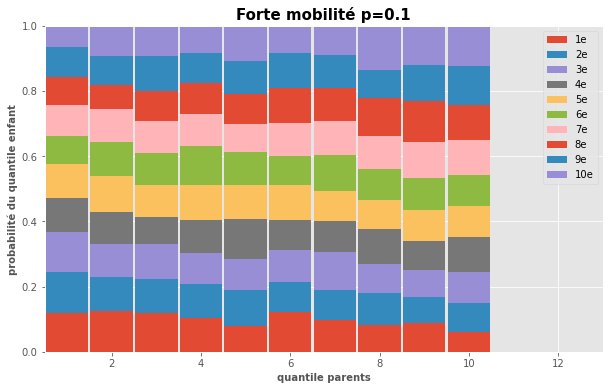

In [27]:
#Exemple d'une forte mobilité avec un pj = 0.1
pj_strong = 0.1                
nb_quantiles_strong = 10       
n_strong  = 1000*nb_quantiles_strong   

y_child_strong, y_parents_strong = generate_incomes(n_strong, pj_strong)
sample_strong = compute_quantiles(y_child_strong, y_parents_strong, nb_quantiles_strong)
cd_strong = conditional_distributions(sample_strong, nb_quantiles_strong)
plot_conditional_distributions_high(pj_strong, cd_strong, nb_quantiles_strong)

In [28]:
#Fonction permettant de visualiser le comportement des distributions conditionnelles 
def plot_conditional_distributions_low(p, cd, nb_quantiles):
    plt.figure(figsize = (10, 6))
    
    # La ligne suivante sert à afficher un graphique en "stack bars", sur ce modèle : https://matplotlib.org/gallery/lines_bars_and_markers/bar_stacked.html
    cumul = np.array([0] * nb_quantiles)
    
    for i, child_quantile in enumerate(cd):
        plt.bar(np.arange(nb_quantiles)+1, child_quantile, bottom=cumul, width=0.95, label = str(i+1) +"e")
        cumul = cumul + np.array(child_quantile)

    plt.axis([.5, nb_quantiles*1.3 ,0 ,1])
    plt.title("Faible mobilité " + "p=" + str(p), fontsize=15, fontweight='bold')
    plt.legend()
    plt.xlabel("quantile parents", fontsize=10, fontweight='bold')
    plt.ylabel("probabilité du quantile enfant", fontsize=10, fontweight='bold')
    
    plt.savefig('graph/distri_cond_faible_mobilite.jpg')
    plt.show()

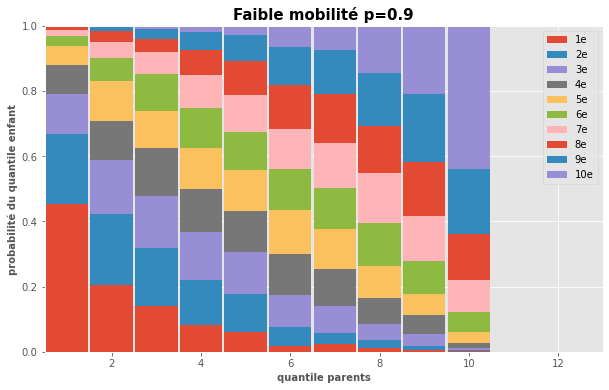

In [29]:
#Exemple d'une très faible mobilité avec un pj = 0.9
pj_low = 0.9                
nb_quantiles_low = 10       
n_low  = 1000*nb_quantiles_low   

y_child_low, y_parents_low = generate_incomes(n_low, pj_low)
sample_low = compute_quantiles(y_child_low, y_parents_low, nb_quantiles_low)
cd_low = conditional_distributions(sample_low, nb_quantiles_low)
plot_conditional_distributions_low(pj_low, cd_low, nb_quantiles_low)

<a id='appli'></a>
<h2 style='color:#6b21eb'>Application du protocole sur nos données</h2>

[Haut de page](#sommaire)


## Nouvel échantillon : 500 fois plus grand que celui de la World Income Distribution
<ol start=8><li>Nous allons maintenant travailler sur un nouvel échantillon. Celui-ci sera créé à partir de la WID. Pour chaque individu de la World Income Distribution, créez-en 499 "clones". La taille de votre nouvel échantillon sera donc 500 fois plus grand que celui de la World Income Distribution.</li></ol>

In [30]:
df_income_mobility

,country,country_code,population,quantile,income,gdpppp,Gini,income_avg,pj
0,Albania,ALB,2947314.0,1,728.89795,7297.00000,0.321410,2994.829902,0.815874
1,Albania,ALB,2947314.0,2,916.66235,7297.00000,0.321410,2994.829902,0.815874
2,Albania,ALB,2947314.0,3,1010.91600,7297.00000,0.321410,2994.829902,0.815874
3,Albania,ALB,2947314.0,4,1086.90780,7297.00000,0.321410,2994.829902,0.815874
4,Albania,ALB,2947314.0,5,1132.69970,7297.00000,0.321410,2994.829902,0.815874
...,...,...,...,...,...,...,...,...,...
11595,Congo Democratic Republic of the,COD,60411195.0,96,810.62330,303.19305,0.459403,276.016044,0.707703
11596,Congo Democratic Republic of the,COD,60411195.0,97,911.78340,303.19305,0.459403,276.016044,0.707703
11597,Congo Democratic Republic of the,COD,60411195.0,98,1057.80740,303.19305,0.459403,276.016044,0.707703
11598,Congo Democratic Republic of the,COD,60411195.0,99,1286.60290,303.19305,0.459403,276.016044,0.707703


<div class="admonition note alert alert-info" style="color:#4cb2ff">
    
<p><b>Note</b></p>
                                                
<p>Le nouveau dataframe ready_db1 obtenu est donc le résultat de la simulation d'individus supplémentaires de notre dataframe original df. Ce nouveau dataframe est composé de 5 800 000 lignes contenant toujours 116 pays. Pour chaque pays, on a donc 50 000 individus et pour chaque centile, 500 individus à revenus égaux. On considère désormais les income comme les y_child.</p>
</div>


## Attribution des classes parents aux 500 individus de chaque pays


<ol start=9><li>Pour chaque \(c_{i,child}\) et chaque pays, il y a maintenant 500 individus. Vous attribuerez aux 500 individus leurs classes \( c_{i,parent}\) conformément aux distributions trouvées précédemment. Par exemple, si \(P(c_{i,parent}=8|c_{i,child}=5,\rho_j=0.9) = 0.03\) , alors vous assignerez la classe \(c_{i,parent} = 8\) à 15 des 500 individus du pays \( j\) ayant \(c_{i,child}=5\) , car 500*0.03 = 15.</li></ol>

### Calcul des c${_{i,parent}}$ 

<div class="admonition note alert alert-info" style="color:#4cb2ff">
Pour plus d'informations sur le calcul du coefficient d'élasticité, consulter ce <a href="https://s3-eu-west-1.amazonaws.com/static.oc-static.com/prod/courses/files/parcours-data-analyst/2011-measuring-intergenerational-income-mobility-art.pdf">document</a>, notamment l'équation 1 de la page 8. Ce coefficient est déterminé par une régression linéaire simple dans laquelle le logarithme du revenu de l'enfant \(Y_{child}\) est une fonction du logarithme du revenu des parents \(Y_{parent}\) :
\[ln(Y_{child}) = \alpha + \rho_j\ ln(Y_{parent}) + \epsilon\] 
</div>

\begin{equation}
\large
y_{parent} = e^{(\Large\frac{ln(y_{child}) - (\alpha + \epsilon)}{\rho_j})}
\end{equation}

In [31]:
df_income_mobility.head(1)

,country,country_code,population,quantile,income,gdpppp,Gini,income_avg,pj
0,Albania,ALB,2947314.0,1,728.89795,7297.0,0.32141,2994.829902,0.815874


In [32]:
df_income_mobility.shape

(11600, 9)

In [33]:
# Clonage des lignes 
ready_db1 = pd.concat([df_income_mobility] * 500)
ready_db1.sort_values(by=['country', 'quantile'], inplace=True)

In [34]:
ready_db1.shape

(5800000, 9)

In [35]:
ready_db1.head(1)

,country,country_code,population,quantile,income,gdpppp,Gini,income_avg,pj
0,Albania,ALB,2947314.0,1,728.89795,7297.0,0.32141,2994.829902,0.815874


In [36]:
# Mise en forme 
ready_db1.rename(columns={'quantile': 'c_i_child', 'income': 'y_child', 'Gini': 'Gj', }, inplace=True)
#ready_db1 = ready_db1[['pays', 'c_i_child', 'y_child', 'Gj', 'pj']]

ready_db1.head(3)

,country,country_code,population,c_i_child,y_child,gdpppp,Gj,income_avg,pj
0,Albania,ALB,2947314.0,1,728.89795,7297.0,0.32141,2994.829902,0.815874
0,Albania,ALB,2947314.0,1,728.89795,7297.0,0.32141,2994.829902,0.815874
0,Albania,ALB,2947314.0,1,728.89795,7297.0,0.32141,2994.829902,0.815874


In [37]:
# Nombre de d'individus générés aléatoirement 1_000 * nb_quantiles
n=100_000

# Préparation des données
nb_quantiles=100
key3 = ready_db1['country'].drop_duplicates().values
c_i_parent = []
ready_db1['c_i_parent'] = 0

In [38]:
# Pour chaque pays
for pays in key3:
    # Selection du pays
    y_child, y_parent = generate_incomes(n, ready_db1.loc[ready_db1['country'] == pays, 'pj'].iloc[0]) 
    # Création des quantiles
    sample = compute_quantiles(y_child, y_parent, nb_quantiles) 
    # Création de l'arrondi du nombre d'individus attendu en fonction des distributions conditionnelles
    cd = np.round(conditional_distributions(sample, nb_quantiles) * 500)
    # Typage en entier
    cd = np.array(cd, int)
    # Passage en dataframe
    cdd = pd.DataFrame(cd)
    # Création de la transposée
    cdt = cdd.T
    # Pour chaque c_i_child
    for cic in np.arange(100):
        # Création d'une liste d'index des valeurs supérieur à 5 grâce à la transposée
        list_random = cdt.loc[cdt[cic] > 5, cic].index.tolist()

        # Si la somme des individus par pays et c_i_child est inférieure à 500 individus
        if cdd.loc[cdd.index == cic].sum().sum() < 500:        
            # Calcul du nombre de valeurs manquantes
            diff = 500 - cdd.loc[cdd.index == cic].sum().sum()
            # Prélèvement d'index dans la liste des valeurs supérieures à 5 individus
            al_ind = random.sample(list_random, diff)
            # Ajout de 1 pour les individus prélévés
            cdd.loc[cdd.index == cic, al_ind] = cdd.loc[cdd.index == cic, al_ind] + 1

        # Si la somme des individus par pays et c_i_child est supérieure à 500 individus
        elif cdd.loc[cdd.index == cic].sum().sum() > 500:
            # Calcul du nombre de valeurs en trop
            diff = cdd.loc[cdd.index == cic].sum().sum() - 500
            # Prélèvement d'index dans la liste des valeurs supérieures à 5 individus
            al_ind = random.sample(list_random, diff)
            # Soustraction de 1 pour les individus prélévés
            cdd.loc[cdd.index == cic, al_ind] = cdd.loc[cdd.index == cic, al_ind] - 1

        # Pour chaque c_i_parent
        for cip in range(0,100):
            # On étend la liste c_i_parent de l'index + 1 de la valeur contenu en c_i_child, c_i_parent
            c_i_parent.extend(np.repeat(cip + 1, cdd.iloc[cic, cip], axis=0))
    # On affecte les valeurs de la liste c_i_parent à la colonne c_i_parent de notre dataframe principale
    ready_db1.loc[(ready_db1['country'] == pays), 'c_i_parent'] = c_i_parent
    # On reinitialise la liste c_i_parent
    c_i_parent =[]

In [39]:
ready_db1

,country,country_code,population,c_i_child,y_child,gdpppp,Gj,income_avg,pj,c_i_parent
0,Albania,ALB,2947314.0,1,728.89795,7297.0,0.321410,2994.829902,0.815874,1
0,Albania,ALB,2947314.0,1,728.89795,7297.0,0.321410,2994.829902,0.815874,1
0,Albania,ALB,2947314.0,1,728.89795,7297.0,0.321410,2994.829902,0.815874,1
0,Albania,ALB,2947314.0,1,728.89795,7297.0,0.321410,2994.829902,0.815874,1
0,Albania,ALB,2947314.0,1,728.89795,7297.0,0.321410,2994.829902,0.815874,1
...,...,...,...,...,...,...,...,...,...,...
11399,Yemen,YEM,21892149.0,100,9050.43750,2224.0,0.390259,1042.635870,0.400000,100
11399,Yemen,YEM,21892149.0,100,9050.43750,2224.0,0.390259,1042.635870,0.400000,100
11399,Yemen,YEM,21892149.0,100,9050.43750,2224.0,0.390259,1042.635870,0.400000,100
11399,Yemen,YEM,21892149.0,100,9050.43750,2224.0,0.390259,1042.635870,0.400000,100


In [40]:
# Suppression de la variable c_i_child inutile pour la mission 4
ready_db1.drop(columns='c_i_child', inplace=True)

In [41]:

 ready_db1.rename(columns={'income_avg': 'mj'}, inplace=True)


In [42]:

# Ajout des colonnes 'logarithmes'
ready_db1['ln_y_child'] = np.log(ready_db1['y_child'])
ready_db1['ln_mj'] = np.log(ready_db1['mj'])

ready_db1

,country,country_code,population,y_child,gdpppp,Gj,mj,pj,c_i_parent,ln_y_child,ln_mj
0,Albania,ALB,2947314.0,728.89795,7297.0,0.321410,2994.829902,0.815874,1,6.591534,8.004643
0,Albania,ALB,2947314.0,728.89795,7297.0,0.321410,2994.829902,0.815874,1,6.591534,8.004643
0,Albania,ALB,2947314.0,728.89795,7297.0,0.321410,2994.829902,0.815874,1,6.591534,8.004643
0,Albania,ALB,2947314.0,728.89795,7297.0,0.321410,2994.829902,0.815874,1,6.591534,8.004643
0,Albania,ALB,2947314.0,728.89795,7297.0,0.321410,2994.829902,0.815874,1,6.591534,8.004643
...,...,...,...,...,...,...,...,...,...,...,...
11399,Yemen,YEM,21892149.0,9050.43750,2224.0,0.390259,1042.635870,0.400000,100,9.110568,6.949507
11399,Yemen,YEM,21892149.0,9050.43750,2224.0,0.390259,1042.635870,0.400000,100,9.110568,6.949507
11399,Yemen,YEM,21892149.0,9050.43750,2224.0,0.390259,1042.635870,0.400000,100,9.110568,6.949507
11399,Yemen,YEM,21892149.0,9050.43750,2224.0,0.390259,1042.635870,0.400000,100,9.110568,6.949507


In [43]:
ready_db1.groupby('country').count().shape

(116, 10)

In [44]:
# Enregistrement du fichier
ready_db1.to_csv('analyse.csv', index=False)

[Haut de page](#sommaire)